In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import ipynb.fs.full.plotFunctions as myplt
import ipynb.fs.full.preprocessFunctions as pp
import ipynb.fs.full.tableFunctions as tab

plt.style.use('Solarize_Light2')

In [2]:
pd.options.display.max_rows = 4000 #this is so that the notebook won't truncate results

In [3]:
test = pd.read_csv("test.csv", index_col="Id")
train = pd.read_csv("train.csv", index_col="Id")

In [4]:
train.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data types

First we will check if all data types were loaded correctly and correct the ones that weren't. By taking a look at the metadata we expect some features to be categorical and some others to be numerical.



In [5]:
meta_cat = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
                'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
                'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'LandSlope']

meta_num = ['SalePrice','LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtUnfSF',
            'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
            'FullBath', 'HalfBath', 'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
            'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
            'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'BsmtFinSF1', 'BsmtFinSF2']

In [6]:
# get the actual numerical columns and object columns loaded
numbers = train.select_dtypes(include='number').columns
objects = train.select_dtypes(include='object').columns

# get columns that were loaded as objects but should have been numerical
print('The following columns should have been numerical, but were not loaded as such:')
print([num for num in meta_num if num not in numbers])

# get columns that were loaded as numbers but should have been objects
print('The following columns were loaded as numbers but are categorical or not listed:')
print([num for num in numbers if num not in meta_num])

# get columns that should be in the dataframe but are not.
print('The following columns were not in the dataframe:')
print([col for col in meta_cat + meta_num if col not in train.columns])

# get columns that are in the dataframe but shouldn't.
print('The following columns were not listed in metadata:')
print([col for col in train.columns if col not in meta_cat + meta_num])


The following columns should have been numerical, but were not loaded as such:
['Bedroom', 'Kitchen']
The following columns were loaded as numbers but are categorical or not listed:
['MSSubClass', 'OverallQual', 'OverallCond', 'BedroomAbvGr', 'KitchenAbvGr']
The following columns were not in the dataframe:
['Bedroom', 'Kitchen']
The following columns were not listed in metadata:
['BedroomAbvGr', 'KitchenAbvGr']


We can see here that some categorical values are numbers: 'MSSubClass', 'OverallQual', 'OverallCond', which will do for later so we'll keep them that way. 
On the other side, 'Bedroom' and 'Kitchen' seem to be named as 'BedroomAbvGr' and 'KitchenAbvGr', we'll rename them.

In [7]:
pp.renameCols(train)

# Target Feature

For starters, we cannot use rows with missing target to train any model. So we'll check this. On the other hand let's take a look at the target distribution.

In [8]:
missing_target = train[train.SalePrice.isna()]
len(missing_target)

0

We have no missing targets.

In [9]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Let's get a visual idea of this distribution

<AxesSubplot:title={'center':'Histogram of SalePrice'}, xlabel='Number of properties', ylabel='Price Range'>

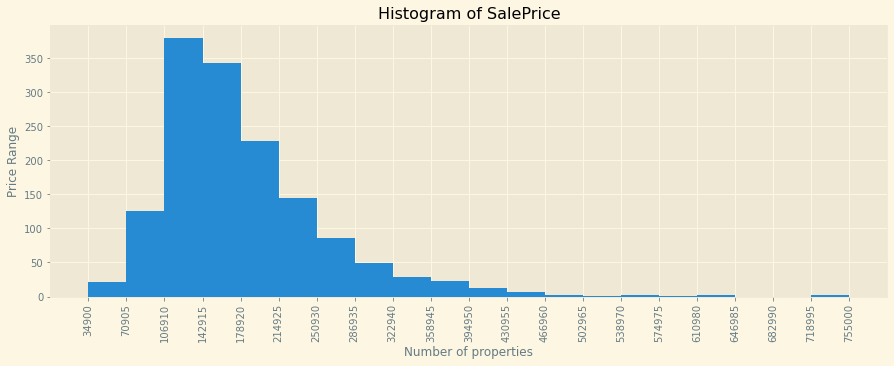

In [10]:
myplt.pltHist(train, 'SalePrice', 20, 'Price Range', 'Number of properties')

We can see that the distribution is skewed: ” In probability theory and statistics, skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.” We want this metric to have a value close to 0. 

In [11]:
train['SalePrice'].skew()

1.8828757597682129

We are clearly far away from this. We'll take the log(SalePrice) instead to see if we can correct this

In [12]:
train['SalePrice'] = np.log(train['SalePrice'])
train['SalePrice'].skew()


0.12133506220520406

<AxesSubplot:title={'center':'Histogram of SalePrice'}, xlabel='Number of properties', ylabel='Price Range'>

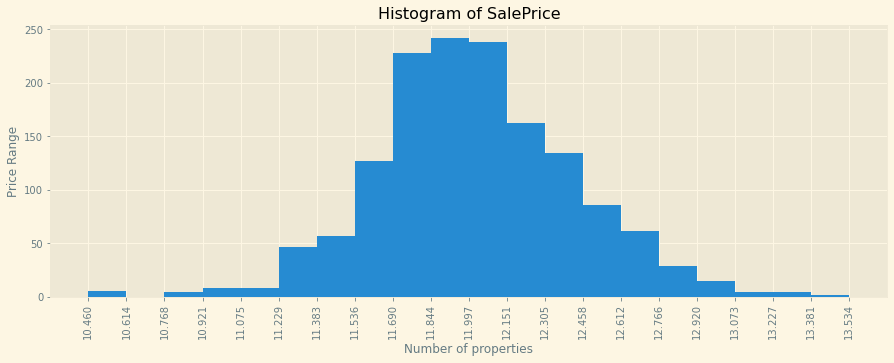

In [13]:
myplt.pltHist(train, 'SalePrice', 20, 'Price Range', 'Number of properties')

Another characteristic we are interested in is kurtosis: "Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case."

In [14]:
train['SalePrice'].kurt()

0.8095319958036296

## Numerical features

In [15]:
print('We have {} numerical features'.format(len(meta_num)-1))

We have 33 numerical features


About these features we would like to know a series of characteristics such as how many distinct values, missing values, its skewness and kurtosis, its correlation to SalePrice. Mean, std, quantiles, max and minimum values. 

In [16]:
df_numInfo = tab.numTable(train[meta_num], 'SalePrice')
df_numInfo.style.background_gradient(subset=['Corr'])

,Count,Mean,Std,Min,25%,50%,75%,Max,Skew,Kurt,% Missing,% Zero,Nuniques,Corr
SalePrice,1460.000000,12.024051,0.399452,10.460242,11.775097,12.001505,12.273731,13.534473,0.121335,0.809532,0.000000,0.000000,663,1.000000
GrLivArea,1460.000000,1515.463699,525.480383,334.000000,1129.500000,1464.000000,1776.750000,5642.000000,1.366560,4.895121,0.000000,0.000000,861,0.700927
GarageCars,1460.000000,1.767123,0.747315,0.000000,1.000000,2.000000,2.000000,4.000000,-0.342549,0.220998,0.000000,5.550000,5,0.680625
GarageArea,1460.000000,472.980137,213.804841,0.000000,334.500000,480.000000,576.000000,1418.000000,0.179981,0.917067,0.000000,5.550000,441,0.650888
TotalBsmtSF,1460.000000,1057.429452,438.705324,0.000000,795.750000,991.500000,1298.250000,6110.000000,1.524255,13.250483,0.000000,2.530000,721,0.612134
1stFlrSF,1460.000000,1162.626712,386.587738,334.000000,882.000000,1087.000000,1391.250000,4692.000000,1.376757,5.745841,0.000000,0.000000,753,0.596981
FullBath,1460.000000,1.565068,0.550916,0.000000,1.000000,2.000000,2.000000,3.000000,0.036562,-0.857043,0.000000,0.620000,4,0.594771
YearBuilt,1460.000000,1971.267808,30.202904,1872.000000,1954.000000,1973.000000,2000.000000,2010.000000,-0.613461,-0.439552,0.000000,0.000000,112,0.586570
YearRemodAdd,1460.000000,1984.865753,20.645407,1950.000000,1967.000000,1994.000000,2004.000000,2010.000000,-0.503562,-1.272245,0.000000,0.000000,61,0.565608
GarageYrBlt,1379.000000,1978.506164,24.689725,1900.000000,1961.000000,1980.000000,2002.000000,2010.000000,-0.649415,-0.418341,5.550000,0.000000,97,0.541073


From this table we can begin to make some decisions:

The following features have low correlation, are highly skewed and most of its values are zero, so they don't seem to be good choices for prediction:

* EnclosedPorch
* LowQualFinSF
* MiscVal
* BsmtHalfBath
* BsmtFinSF2
* 3SsnPorch
* Pool Area
* ScreenPorch

--

* Kitchen is still highly skewed and low correlated so we will dismiss it also

* MoSold and YrSold have low correlation although one would tend to think that this is info one gets after already having a defined price. May be one interesting value would be the difference in years between the Year the property was built or remodeled and the Year it was sold.


**The good ones**

These features have good correlation and nice skew values:

* GarageCars
* GarageArea
* FullBath
* YearBuilt
* YearRemodAdd
* GarageYrBuilt
* TotRmsAvbGrd
* FirePlaces
* 2ndFlrSF

Good correlation:

* HalfBath
* BsmtFullBath
* BsmtUnfSF
* Bedroom


**The ones to work with**

These have great correlation but are highly skewed

* GrLivArea
* TotalBsmtSF
* 1stFlrSF

These have good correlation and highly skewed

* MasVnrArea
* BsmtFinSF1
* LotFrontage
* WoodDeckSF
* OpenPorchSF
* LotArea





Let's keep track of the features we will dismiss for prediction, and take a visual look at the remaining ones

In [17]:
corr_idx = list(df_numInfo.index)

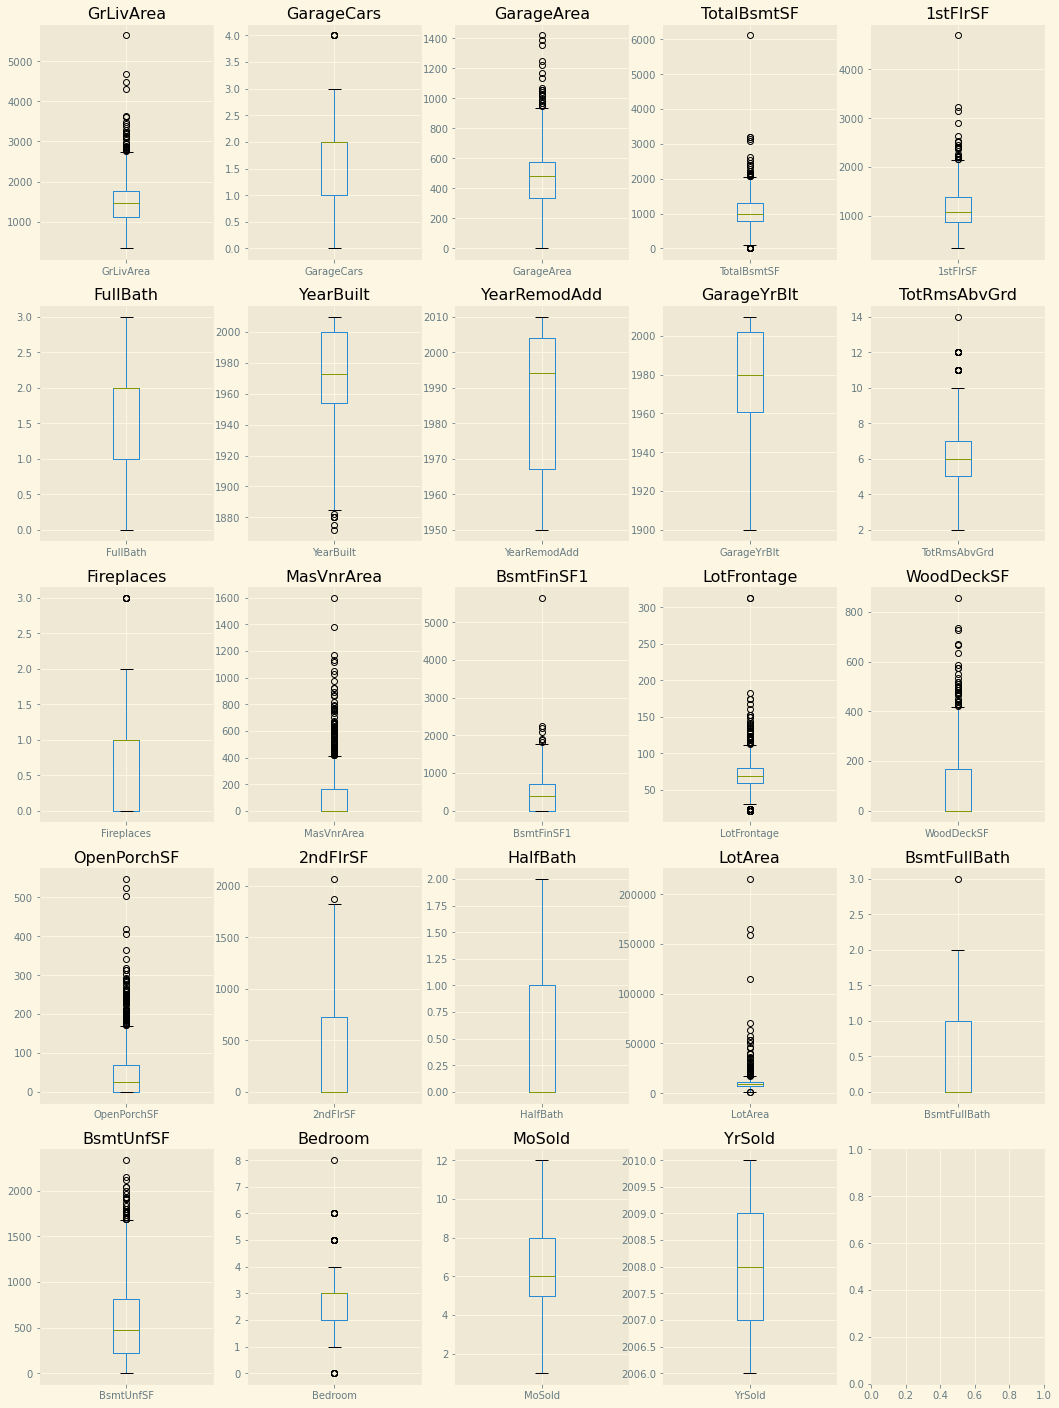

In [18]:
#We'll keep track of the features we'll dismiss in a list
dismiss = ['EnclosedPorch', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch', 'PoolArea', 'ScreenPorch', 'Kitchen']

num = [col for col in corr_idx if col not in dismiss]
num.remove('SalePrice')

fig_numericals = myplt.plotNumBoxList(train, num)

### Possible Outliers

GarageCars, YearBuilt, TotRmsAbvGrd, Fireplaces, 2ndFlrSF, BsmtFullBath, BsmtUnfSF and Bedroom all seem to have possible outliers. Let's take a deep look on them

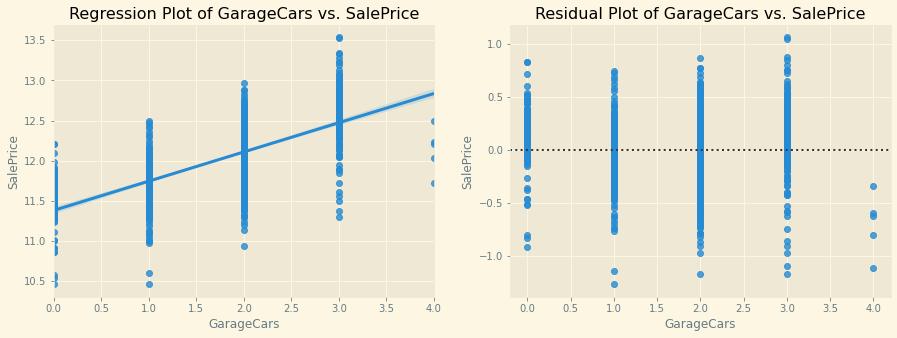

In [19]:
fig_gc = myplt.plotRegRes(train, 'GarageCars', 'SalePrice')

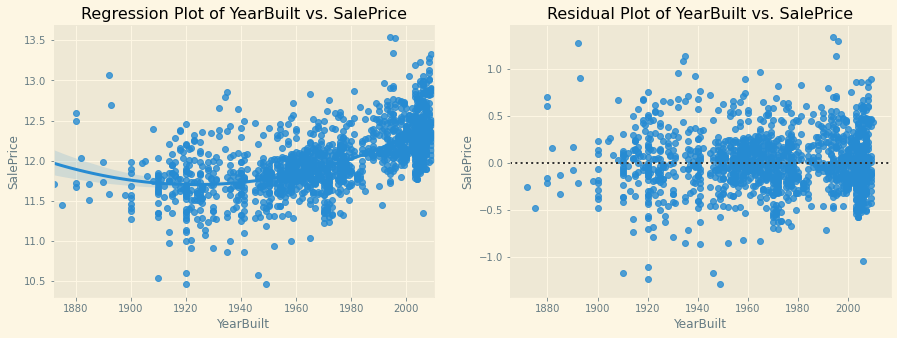

In [20]:
# YearBuilt feature seems better fitted by a 2nd order polynomial
fig_gc = myplt.plotRegRes(train, 'YearBuilt', 'SalePrice', 2)

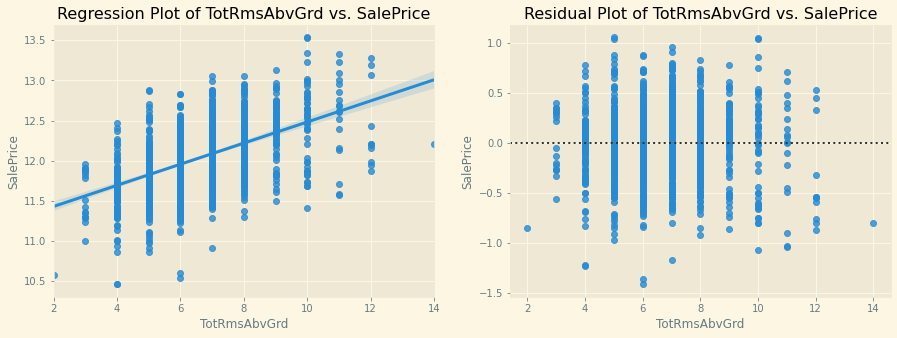

In [21]:
fig_gc = myplt.plotRegRes(train, 'TotRmsAbvGrd', 'SalePrice')

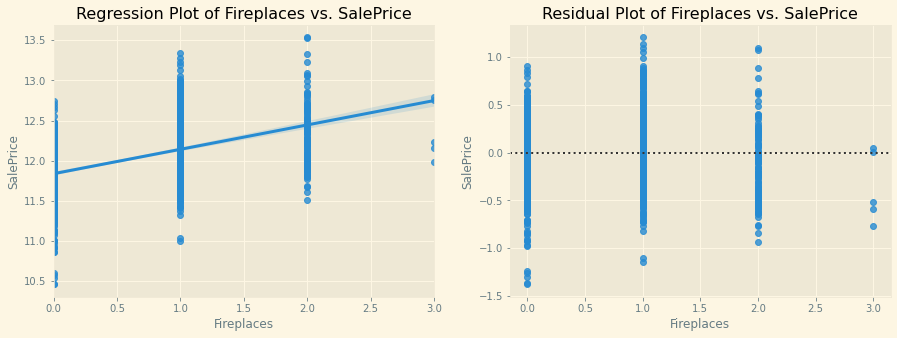

In [22]:
fig_gc = myplt.plotRegRes(train, 'Fireplaces', 'SalePrice')

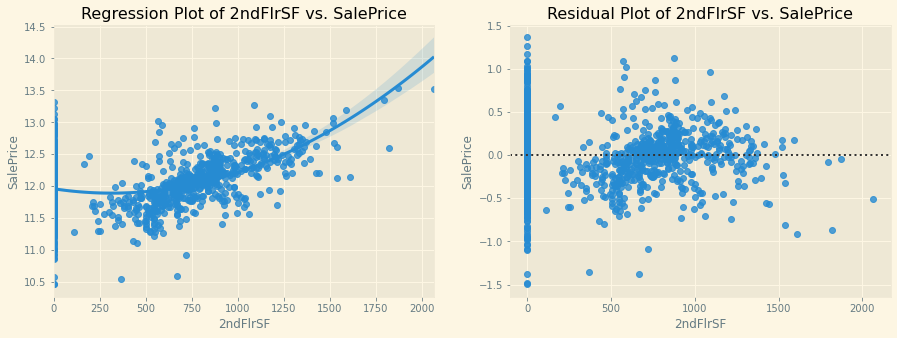

In [23]:
fig_gc = myplt.plotRegRes(train, '2ndFlrSF', 'SalePrice', 2)

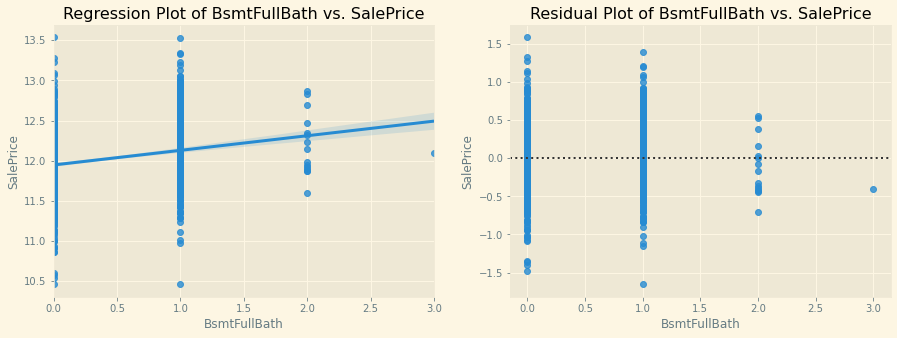

In [24]:
fig_gc = myplt.plotRegRes(train, 'BsmtFullBath', 'SalePrice')

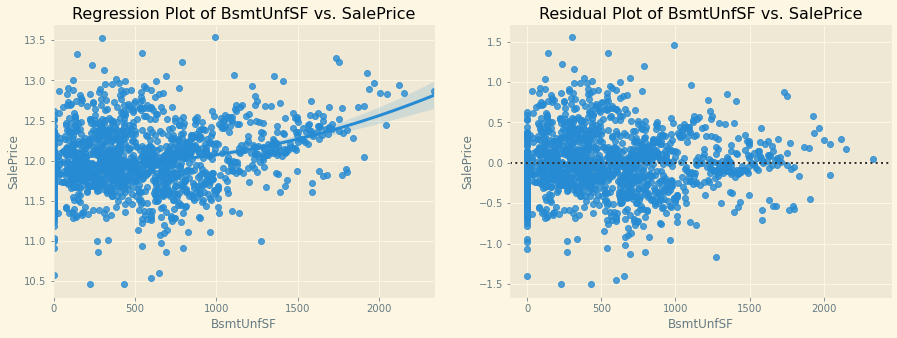

In [25]:
fig_gc = myplt.plotRegRes(train, 'BsmtUnfSF', 'SalePrice', 2)

fig_gc = myplt.plotRegRes(train, 'Bedroom', 'SalePrice')

In [26]:
pd.concat([train[train['TotRmsAbvGrd'] == 14], train[train['Bedroom'] == 8], train[train['BsmtFullBath'] == 3]], axis=0)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,12.206073
636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,12.206073
739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,12.095141


### The skewed ones

TotalBsmtSF has zero values, so we can't calculate log on it just as it is, let's take a deeper look 

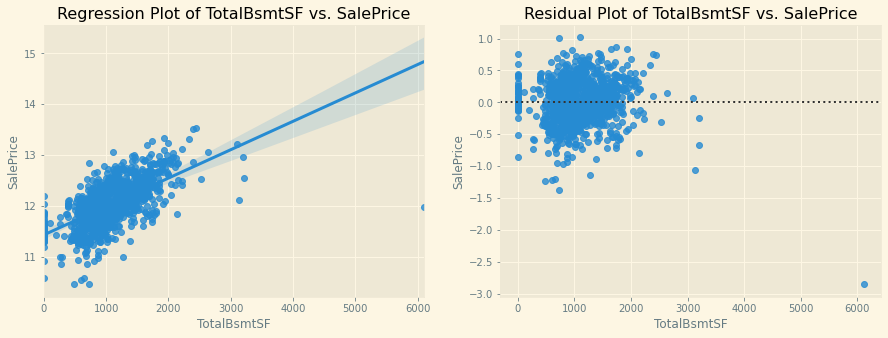

In [27]:
fig_tbsf = myplt.plotRegRes(train, 'TotalBsmtSF', 'SalePrice')

In [28]:
#We have a very clear outlier
train[train['TotalBsmtSF']> 6000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,11.982929


We will remove this outlier and keep track of removed outliers in a list.

In [29]:
outliers = list(train[train['TotalBsmtSF'] > 6000].index)
train = train[train['TotalBsmtSF'] < 6000]
outliers

[1299]

In [30]:
train['TotalBsmtSF'].skew()

0.5736369416201317

In [31]:
train['TotalBsmtSF'].kurt()

2.0290806702986632

As we can see, just by eliminating this outlier we have achieved the desired values for skew and kurt. Let's see if this has made any change on the other skewed variables

0.9524102073822629


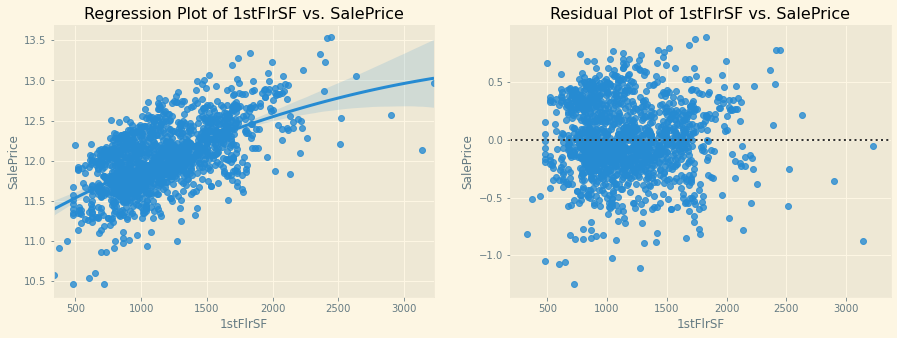

In [32]:
print(train['1stFlrSF'].skew())
fig_glva = myplt.plotRegRes(train, '1stFlrSF', 'SalePrice', 2)

In [33]:
#We still seem to have a few outliers
train[train['1stFlrSF']> 2700]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
497,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.971540
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,12.126759
1025,20,RL,NaN,15498,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2008,COD,Abnorml,12.567237


Skewness is better but still not quite the value we'd like. We will eliminate index 524 since this property seems to be an outlier in several features.

In [34]:
train.drop(index=[524], inplace=True)
outliers.append(524)

1.0109917025385513


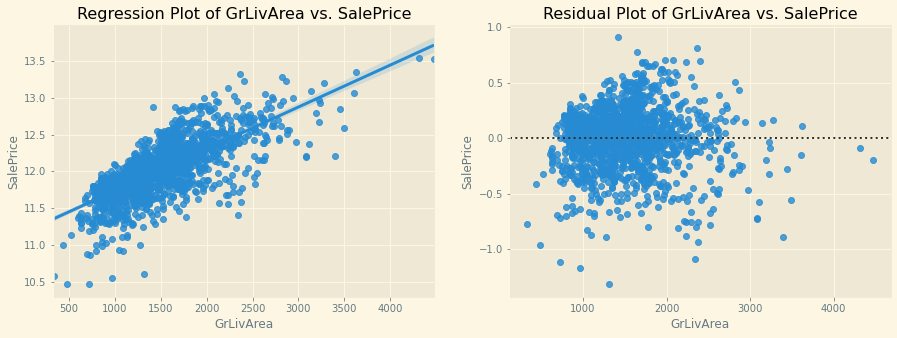

In [35]:
print(train['GrLivArea'].skew())
fig_glva = myplt.plotRegRes(train, 'GrLivArea', 'SalePrice', 1)

GrLivArea is still lightly skewed, but this could be fixed by scaling the data later, so we'll work with it.

#### Highly skewed

2.6877840195436478


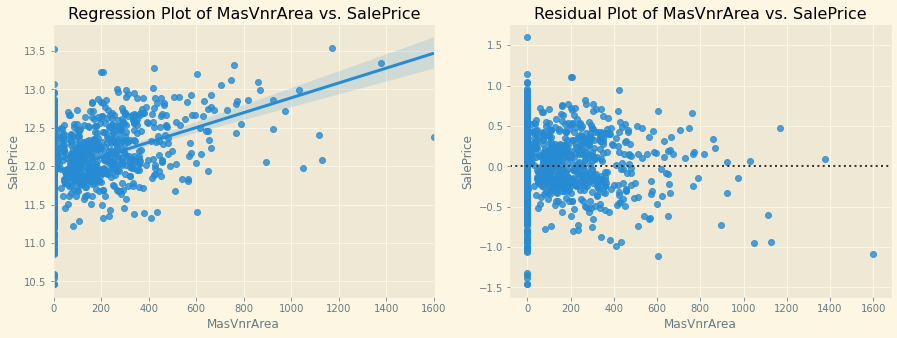

In [36]:
print(train['MasVnrArea'].skew())
fig_mva = myplt.plotRegRes(train, 'MasVnrArea', 'SalePrice')

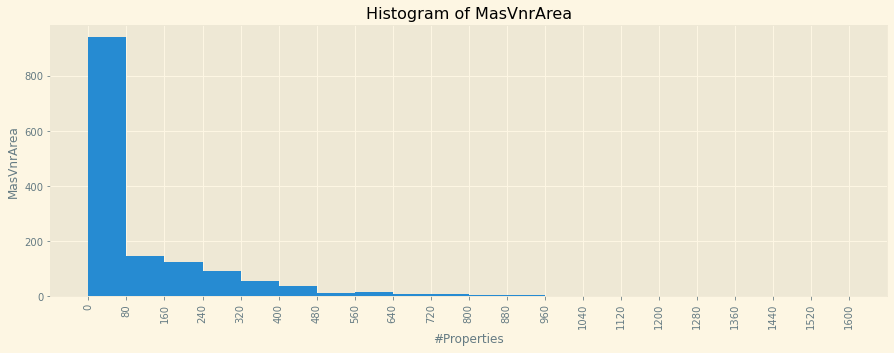

In [37]:
train['MasVnrArea'].fillna(train['MasVnrArea'].mean(), inplace=True)
hist_mva = myplt.pltHist(train, 'MasVnrArea', 20, 'MasVnrArea', '#Properties')

Almost 60% of the values are zero, so we can't apply log here, we will see what we can do with it later, we'll keep track of it in a skewed list


In [38]:
skewed=['MasVnrArea']

0.7647894513451676


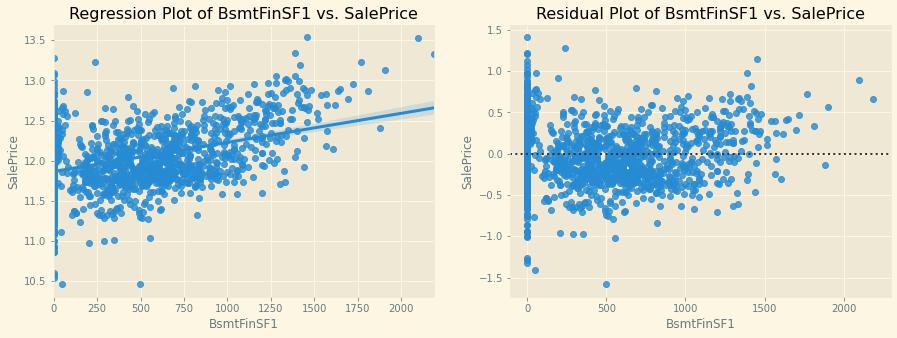

In [39]:
print(train['BsmtFinSF1'].skew())
fig_mva = myplt.plotRegRes(train, 'BsmtFinSF1', 'SalePrice')

In [40]:
train['BsmtFinSF1'].kurt()

-0.11209773018937907

1.5430431199713504
11.52953612041342


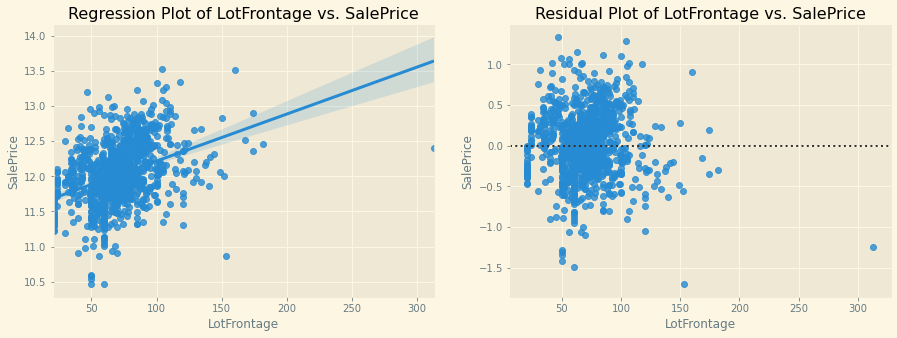

In [41]:
print(train['LotFrontage'].skew())
print(train['LotFrontage'].kurt())
fig_mva = myplt.plotRegRes(train, 'LotFrontage', 'SalePrice')

In [42]:
train[train['LotFrontage']>300]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,12.396693


In [43]:
print(train[train['LotFrontage']<300]['LotFrontage'].skew())
print(train[train['LotFrontage']<300]['LotFrontage'].kurt())

0.6977324167197465
2.362427689158153


We'll drop id 935 as outlier

In [44]:
train.drop(index=[935], inplace=True)
outliers.append(935)

1.5449166882127714
3.0030562206104494


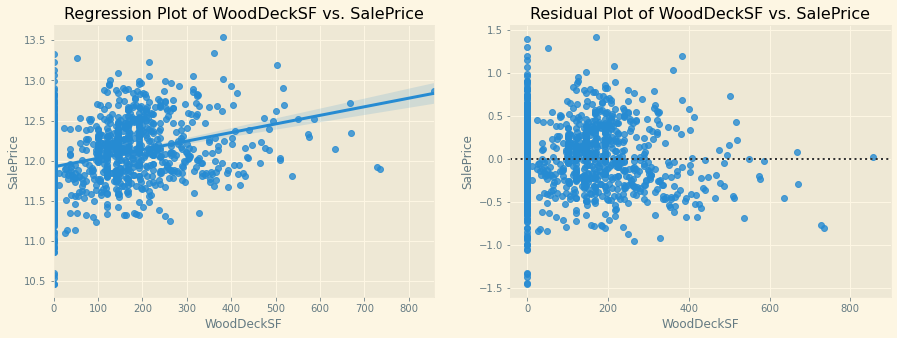

In [45]:
print(train['WoodDeckSF'].skew())
print(train['WoodDeckSF'].kurt())
fig_mva = myplt.plotRegRes(train, 'WoodDeckSF', 'SalePrice')

2.339020748971797
8.471638101198971


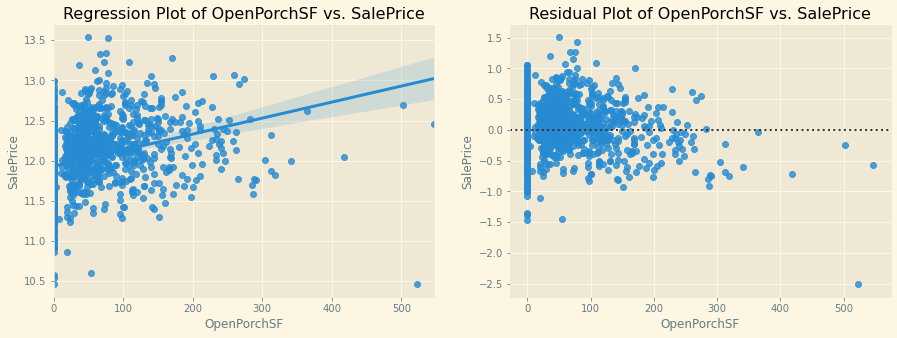

In [46]:
print(train['OpenPorchSF'].skew())
print(train['OpenPorchSF'].kurt())
fig_mva = myplt.plotRegRes(train, 'OpenPorchSF', 'SalePrice')

12.609035123571356
214.40347884362876


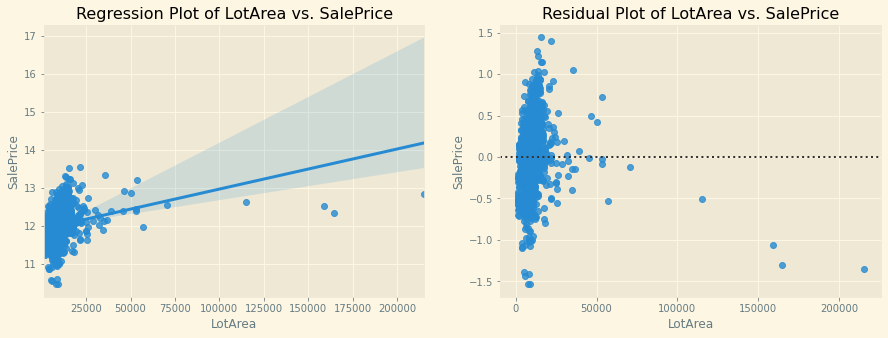

In [47]:
print(train['LotArea'].skew())
print(train['LotArea'].kurt())
fig_mva = myplt.plotRegRes(train, 'LotArea', 'SalePrice')

Lot Area seems to have several outliers, which we are not sure if we want to dismiss yet. But just as it is, Lot Area does not seem to be a great feature for prediction. Let's dismiss it and see what we can do with it later.

In [48]:
skewed.extend(['LotFrontage', 'WoodDeckSF', 'OpenPorchSF', 'LotArea'])

## Categorical Features

In [49]:
print('We have {} categorical features'.format(len(meta_cat)))

We have 46 categorical features


In [50]:
df_catInfo = tab.catTable(train[meta_cat])
df_catInfo

,Count,Unique,Top,Freq,% Missing
PoolQC,1457,4,nan,1451,99.588195
MiscFeature,1457,5,nan,1403,96.293754
Alley,1457,3,nan,1366,93.754290
Fence,1457,5,nan,1176,80.713795
FireplaceQu,1457,6,nan,690,47.357584
GarageType,1457,7,Attchd,868,5.559369
GarageQual,1457,6,TA,1308,5.559369
GarageFinish,1457,4,Unf,605,5.559369
GarageCond,1457,6,TA,1323,5.559369
BsmtFinType2,1457,7,Unf,1253,2.608099


We will dismiss the features with more than 80% of missing values: 
* PoolQC
* MiscFeature
* Alley
* Fence

In [51]:
dismiss.extend(['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

What about Fireplace quality, we seem to have many missing values, but this could be related to properties not having fireplaces.

In [52]:
print('Missing values on properties with fireplaces: {}'.format(train[train['Fireplaces']>0]['FireplaceQu'].isna().sum()))

Missing values on properties with fireplaces: 0


So in this case we could replace nulls with a new category meaning it doesn't apply to this property. On the other hand, let's see how quality of fireplaces relates to price

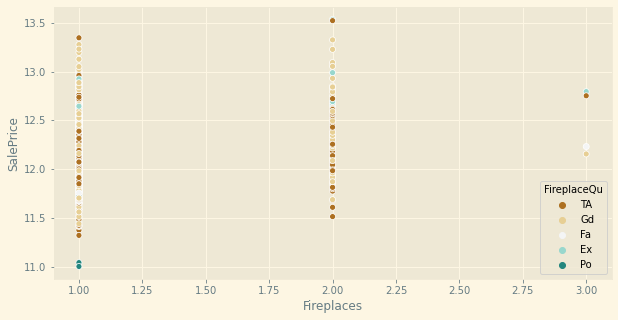

In [53]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='Fireplaces', y='SalePrice', hue=list(train['FireplaceQu']), palette= 'BrBG')
ax.legend(title='FireplaceQu')

#### Garage Type, Finish, Quality and Condition
This features also have missing values, is this related to houses with no garages

In [54]:
train[train['GarageArea'] > 0][['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].isna().sum()

GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

As we can see here also, missing values imply that the feature does not apply for that property. Once again we can replace missing values with a new label.

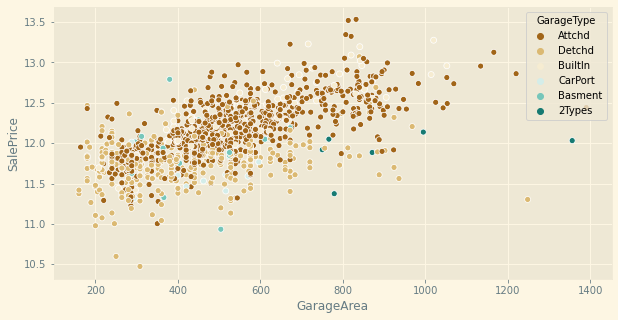

In [55]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='GarageArea', y='SalePrice', hue=list(train['GarageType']), palette= 'BrBG')
ax.legend(title='GarageType')

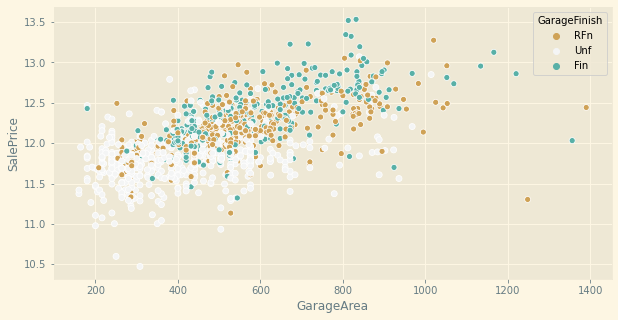

In [56]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='GarageArea', y='SalePrice', hue=list(train['GarageFinish']), palette= 'BrBG')
ax.legend(title='GarageFinish')

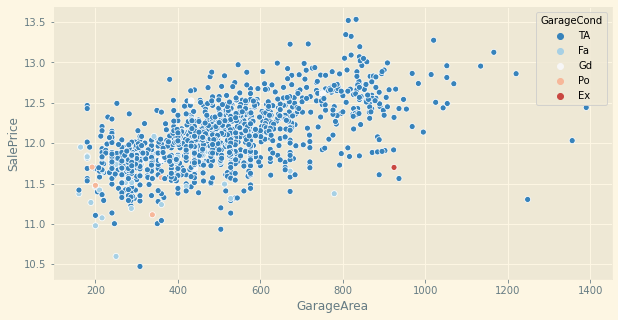

In [57]:
plt.figure(figsize=(10,5))
ax= sns.scatterplot(data=train, x='GarageArea', y='SalePrice', hue=list(train['GarageCond']), palette= 'RdBu_r')
ax.legend(title='GarageCond')

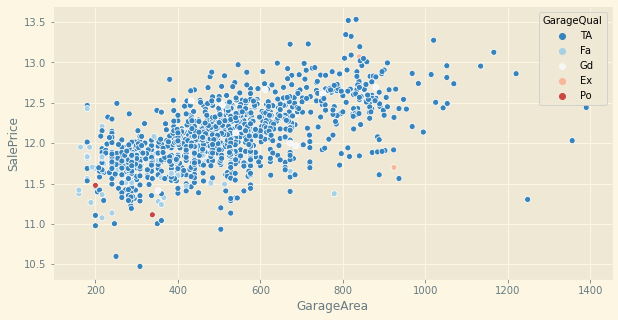

In [58]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='GarageArea', y='SalePrice', hue=list(train['GarageQual']), palette= 'RdBu_r')
ax.legend(title='GarageQual')

Both GarageQuality and Condition concentrate more than 80% of the properties on one category: typical/average, and then we have excelent properties with both high and low prices so they might not be great features for prediction. We'll leave them out for the time being.

In [59]:
dismiss.extend(['GarageQual', 'GarageCond'])

#### Basement Type 1, 2, Condition, Exposure and Quality

Once again we have missing values here is this related to properties with Total Basement SF = 0

In [60]:
train[train['TotalBsmtSF'] > 0][['BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure']].isna().sum()

BsmtFinType1    0
BsmtFinType2    1
BsmtQual        0
BsmtCond        0
BsmtExposure    1
dtype: int64

Both Basemnt Exposure and Basment FinType2 have missing values in properties wiht more than 0 SF

In [61]:
train[(train['TotalBsmtSF'] > 0) & (train['BsmtFinType1'].isna() | train['BsmtExposure'].isna())]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
949,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2006,WD,Normal,12.167851


It is in fact the same property. We might consider filling this ones with the mean value. The rest with a new label. Or just apply the new label to every property.

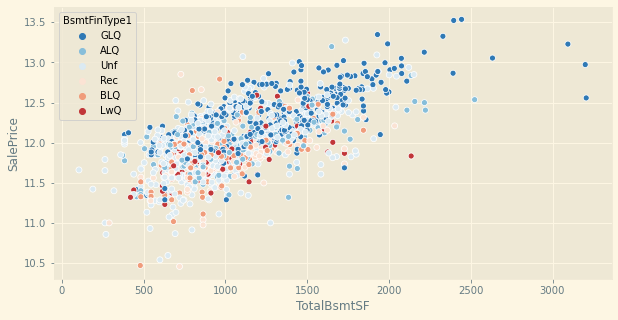

In [62]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice', hue=list(train['BsmtFinType1']), palette= 'RdBu_r')
ax.legend(title='BsmtFinType1')

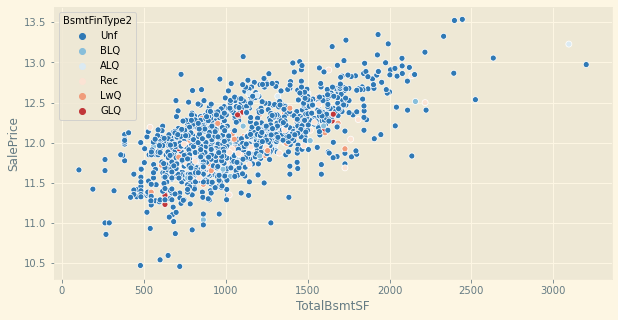

In [63]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice', hue=list(train['BsmtFinType2']), palette= 'RdBu_r')
ax.legend(title='BsmtFinType2')

We should consider combining both Types in one category

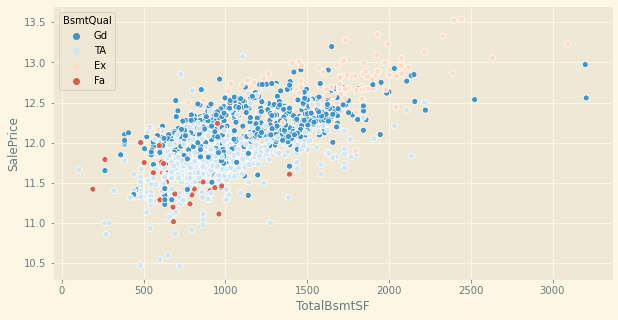

In [64]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice', hue=list(train['BsmtQual']), palette= 'RdBu_r')
ax.legend(title='BsmtQual')

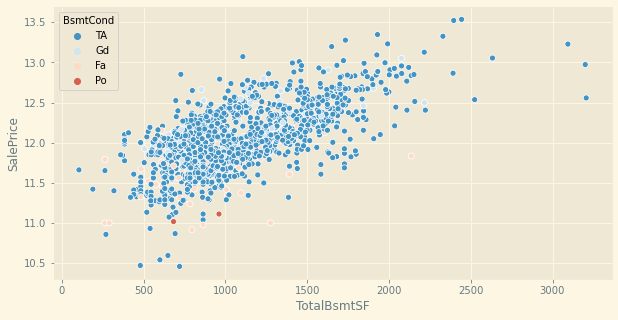

In [65]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice', hue=list(train['BsmtCond']), palette= 'RdBu_r')
ax.legend(title='BsmtCond')

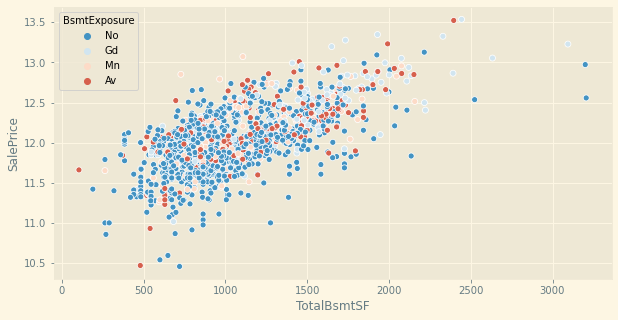

In [66]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice', hue=list(train['BsmtExposure']), palette= 'RdBu_r')
ax.legend(title='BsmtExposure')

#### MasVnrType
Again too many missing values, probably related to MasVnrArea = 0

In [67]:
train[train['MasVnrArea'] > 0][['MasVnrType']].isna().sum()

MasVnrType    8
dtype: int64

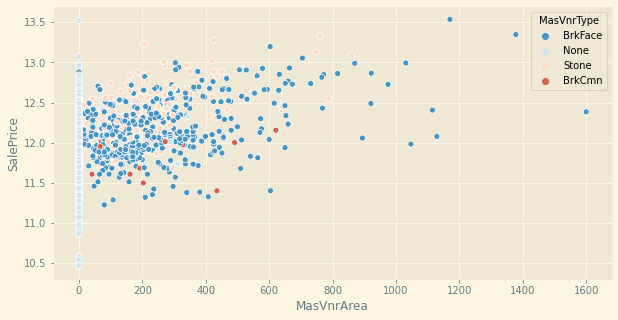

In [68]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='MasVnrArea', y='SalePrice', hue=list(train['MasVnrType']), palette= 'RdBu_r')
ax.legend(title='MasVnrType')

#### Electrical
Has a few missing values, we'll impute them with a new label

#### Lot shape, Land Contour, LotConfig, LandSlope

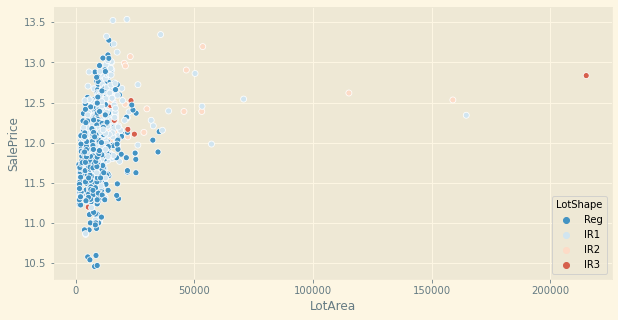

In [69]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='LotArea', y='SalePrice', hue=list(train['LotShape']), palette= 'RdBu_r')
ax.legend(title='LotShape')

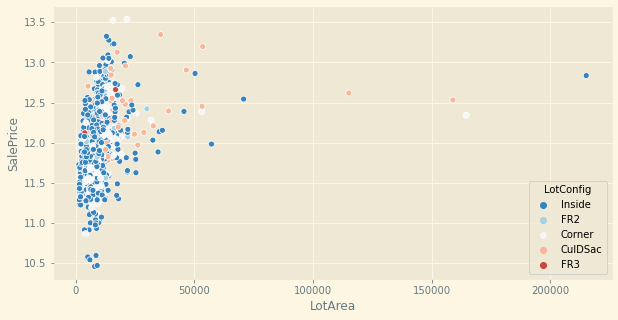

In [70]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='LotArea', y='SalePrice', hue=list(train['LotConfig']), palette= 'RdBu_r')
ax.legend(title='LotConfig')

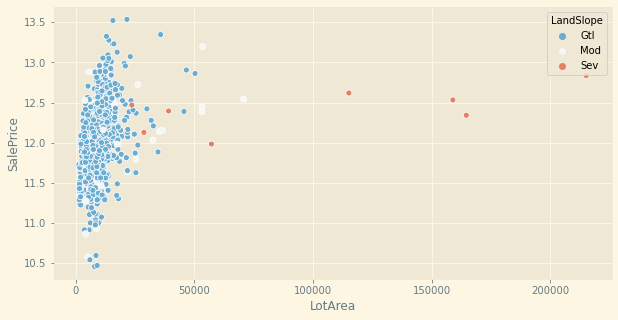

In [71]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='LotArea', y='SalePrice', hue=list(train['LandSlope']), palette= 'RdBu_r')
ax.legend(title='LandSlope')

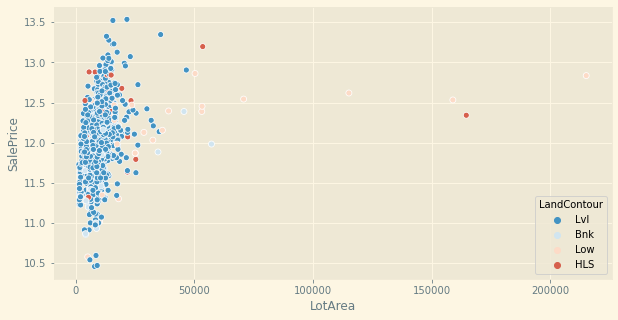

In [72]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='LotArea', y='SalePrice', hue=list(train['LandContour']), palette= 'RdBu_r')
ax.legend(title='LandContour')

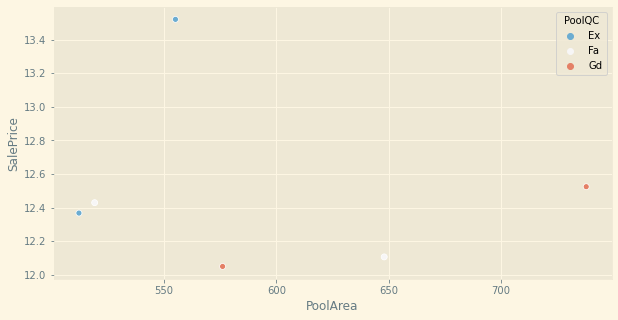

In [73]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=train, x='PoolArea', y='SalePrice', hue=list(train['PoolQC']), palette= 'RdBu_r')
ax.legend(title='PoolQC')

**The ammount of categorical features is quite overwhelming. They all seem to add up a little info but I'm not quite sure yet what to do with them. Eventually we will encode them in a numerical way so that we can use them for prediction, may be we could see how this numerical encoding correlates to SalePrice?
We could also create some bivariates to see if they improve the skewness and correlation of their univariates**

In [74]:
train['Conditions'] = train['Condition1'] + '-' + train['Condition2']
train['Overall'] = train['OverallQual'].astype(str) + '-' + train['OverallCond'].astype(str)
train['Roof'] = train['RoofStyle'] + '-' + train['RoofMatl']
train['Exterior'] = train['Exterior1st'] + '-' + train['Exterior2nd']
train['External'] = train['ExterQual'] + '-' + train['ExterCond']
train['Basement'] = train['BsmtQual'] + '-' + train['BsmtCond']
train['BasementFin'] = train['BsmtFinType1'] + '-' + train['BsmtFinType2']
train['Garage'] = train['GarageQual'] + '-' + train['GarageCond']
train['GarageTF'] = train['GarageType'] + '-' + train['GarageFinish']
train['HeatingCond'] = train['Heating'] + '-' + train['HeatingQC']
train['Sale'] = train['SaleType'] + '-' + train['SaleCondition']
train['Lot'] = train['LotShape'] + '-' + train['LotConfig']
    
meta_cat.extend(['Conditions', 'Overall', 'Roof', 'Exterior', 'External', 'Basement', 'BasementFin', 'Garage', 'GarageTF', 'HeatingCond', 'Sale', 'Lot'])

In [75]:
import category_encoders as ce
train[meta_cat].fillna(value='DNA', inplace=True)
cb_enc = ce.CatBoostEncoder(cols=meta_cat)
cb_enc.fit(train[meta_cat], train['SalePrice'])
encoded = pd.concat([cb_enc.transform(train[meta_cat]),train['SalePrice']],axis=1)
encoded.head()

C:\Users\lauri_almadeartista\Miniconda3\envs\py37\lib\site-packages\pandas\core\frame.py:4320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\lauri_almadeartista\Miniconda3\envs\py37\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,Neighborhood,Condition1,...,Exterior,External,Basement,BasementFin,Garage,GarageTF,HeatingCond,Sale,Lot,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,12.340827,12.085614,12.025225,12.037377,11.936188,12.022695,12.023885,12.001426,12.162715,12.042901,...,12.211522,12.313264,12.175649,12.310566,12.074778,12.181838,12.207748,12.007915,11.937946,12.247694
2,12.052092,12.085614,12.025225,12.037377,11.936188,12.022695,12.023885,12.034512,12.317474,11.818838,...,11.863908,11.843162,12.175649,11.934184,12.074778,12.181838,12.207748,12.007915,11.980687,12.109011
3,12.340827,12.085614,12.025225,12.037377,12.163253,12.022695,12.023885,12.001426,12.162715,12.042901,...,12.211522,12.313264,12.175649,12.310566,12.074778,12.181838,12.207748,12.007915,12.153408,12.317167
4,11.965024,12.085614,12.025225,12.037377,12.163253,12.022695,12.023885,12.027601,12.203141,12.042901,...,11.834101,11.843162,12.070981,11.934184,12.074778,11.757858,11.910546,11.788138,12.178806,11.849398
5,12.340827,12.085614,12.025225,12.037377,12.163253,12.022695,12.023885,12.034512,12.660470,12.042901,...,12.211522,12.313264,12.175649,12.310566,12.074778,12.181838,12.207748,12.007915,12.080111,12.429216


In [81]:
df_numCatInfo = tab.numTable(encoded, 'SalePrice', describe=False).add_suffix('_catBoost')
df_numCatInfo.style.background_gradient(subset=['Corr_catBoost'])

,Skew_catBoost,Kurt_catBoost,% Missing_catBoost,% Zero_catBoost,Nuniques_catBoost,Corr_catBoost
SalePrice,0.123000,0.806498,0.000000,0.000000,662,1.000000
OverallQual,0.531248,0.148900,0.000000,0.000000,10,0.823441
Overall,0.527442,0.109357,0.000000,0.000000,41,0.813035
Neighborhood,0.365441,-0.497286,0.000000,0.000000,25,0.756733
External,0.760101,0.264782,0.000000,0.000000,11,0.689615
Basement,0.638840,0.113701,0.000000,0.000000,12,0.686538
ExterQual,0.798650,0.020864,0.000000,0.000000,4,0.683023
BsmtQual,0.656703,-0.012796,0.000000,0.000000,5,0.674654
KitchenQual,0.554673,-0.401052,0.000000,0.000000,4,0.671097
GarageTF,-0.233669,-1.103680,0.000000,0.000000,17,0.656469


Here we can select a bunch of highly skewed low correlated variables to dismiss:

    * Utilities
    * Land Slope
    * Street
    * Condition2
    * PoolQC
    * MiscFeature
    * RoofMatl
    * Functional
    
Amongst the new bivariates we can dismiss:

    * 'Overall'
    
And we should keep:

    * 'Conditions' instead of Condition1 and 2
    * 'Roof' instead of 'RoofStyle' and 'RoofMtl'
    * 'Exterior' instead of 'Exterior1st' and 'Exterior2nd'
    * 'External' instead of 'ExternalQual' and 'ExternalCond'
    * 'Basement' instead of 'BasementQual' and 'BasementCond'
    * 'BasementFin' instead of 'BasementFinType1' and 'BasementFinType2'
    * 'Garage' instead of 'GarageQual' and 'GarageCond'
    * 'GarageTF' instead of 'GarageType' and 'GarageFinish'
    * 'HeatingCond' intead of 'HeatingQC' and 'Heating'
    * 'Sale' instead of 'SaleType' and SaleCond'
    * 'Lot' instead of 'LotShape' and 'LotConfig'
    
Let's add the first list to the dismiss list. The rest of the features we'll have to dismiss them after having created the bivariate ones, so we'll just make a dictionary of bivariates to keep track of this.

In [77]:
dismiss.extend(['Utilities', 'LandSlope', 'Street', 'PoolQC', 'MiscFeature', 'Functional'])
catBivs = {'Conditions': ('Condition1', 'Condition2'),
           'Roof': ('RoofStyle', 'RoofMatl'),
           'Exterior': ('Exterior1st', 'Exterior2nd'),
           'External':('ExterQual','ExterCond'),
           'Basement':('BsmtQual','BsmtCond'),
           'BasementFin': ('BsmtFinType1', 'BsmtFinType2'),
           'Sale':('SaleType','SaleCondition'),
           'Garage': ('GarageQual', 'GarageCond'),
           'GarageTF': ('GarageType', 'GarageFinish'),
           'HeatingCond': ('Heating', 'HeatingQC'),
           'Lot': ('LotShape', 'LotConfig')}

### Different Encodings

After making a first model using CatBoostEncoder, let's see what happens with different encoding methods.

#### One Hot Encoder

In [79]:
oneHot_enc = ce.OneHotEncoder(cols=meta_cat)
oneHot_enc.fit(train[meta_cat], train['SalePrice'])
oneHotEncoded = pd.concat([oneHot_enc.transform(train[meta_cat]),train['SalePrice']],axis=1)
oneHotEncoded.head()

C:\Users\lauri_almadeartista\Miniconda3\envs\py37\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSSubClass_5,MSSubClass_6,MSSubClass_7,MSSubClass_8,MSSubClass_9,MSSubClass_10,...,Lot_9,Lot_10,Lot_11,Lot_12,Lot_13,Lot_14,Lot_15,Lot_16,Lot_17,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.247694
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.109011
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.317167
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.849398
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.429216


In [84]:
df_oneHotCatInfo = tab.numTable(oneHotEncoded, 'SalePrice', describe=False).add_suffix('_oneHot')
df_oneHotCatInfo.head(15).style.background_gradient(subset=['Corr_oneHot'])


,Skew_oneHot,Kurt_oneHot,% Missing_oneHot,% Zero_oneHot,Nuniques_oneHot,Corr_oneHot
SalePrice,0.123000,0.806498,0.000000,0.000000,662,1.000000
Foundation_1,0.230997,-1.949318,0.000000,55.730000,2,0.532067
ExterQual_1,0.700198,-1.511800,0.000000,66.510000,2,0.510634
External_1,0.817868,-1.332924,0.000000,68.910000,2,0.487735
BsmtQual_3,3.058086,7.361991,0.000000,91.830000,2,0.467555
HeatingQC_1,-0.026110,-2.002068,0.000000,49.350000,2,0.466588
HeatingCond_1,-0.020613,-2.002326,0.000000,49.490000,2,0.465851
Basement_3,3.254628,8.604415,0.000000,92.590000,2,0.462277
BsmtFinType1_1,0.954459,-1.090508,0.000000,71.520000,2,0.440861
BasementFin_1,1.054525,-0.889200,0.000000,73.300000,2,0.434292


One Hot encoding leaves us with more than 580 features, with much less correlation and some of them highly skewed. Using one hot encoding I think should be combined with some feature selection afterwards

#### Backward Difference Encoder

In [85]:
bd_enc = ce.BackwardDifferenceEncoder(cols=meta_cat)
bd_enc.fit(train[meta_cat], train['SalePrice'])
bdEncoded = pd.concat([bd_enc.transform(train[meta_cat]),train['SalePrice']],axis=1)
bdEncoded.head()

C:\Users\lauri_almadeartista\Miniconda3\envs\py37\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,intercept,MSSubClass_0,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSSubClass_5,MSSubClass_6,MSSubClass_7,MSSubClass_8,...,Lot_7,Lot_8,Lot_9,Lot_10,Lot_11,Lot_12,Lot_13,Lot_14,Lot_15,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,1,-0.933333,-0.866667,-0.8,-0.733333,-0.666667,-0.6,-0.533333,-0.466667,-0.4,...,-0.529412,-0.470588,-0.411765,-0.352941,-0.294118,-0.235294,-0.176471,-0.117647,-0.058824,12.247694
2,1,0.066667,-0.866667,-0.8,-0.733333,-0.666667,-0.6,-0.533333,-0.466667,-0.4,...,-0.529412,-0.470588,-0.411765,-0.352941,-0.294118,-0.235294,-0.176471,-0.117647,-0.058824,12.109011
3,1,-0.933333,-0.866667,-0.8,-0.733333,-0.666667,-0.6,-0.533333,-0.466667,-0.4,...,-0.529412,-0.470588,-0.411765,-0.352941,-0.294118,-0.235294,-0.176471,-0.117647,-0.058824,12.317167
4,1,0.066667,0.133333,-0.8,-0.733333,-0.666667,-0.6,-0.533333,-0.466667,-0.4,...,-0.529412,-0.470588,-0.411765,-0.352941,-0.294118,-0.235294,-0.176471,-0.117647,-0.058824,11.849398
5,1,-0.933333,-0.866667,-0.8,-0.733333,-0.666667,-0.6,-0.533333,-0.466667,-0.4,...,-0.529412,-0.470588,-0.411765,-0.352941,-0.294118,-0.235294,-0.176471,-0.117647,-0.058824,12.429216


In [86]:
df_bdCatInfo = tab.numTable(bdEncoded, 'SalePrice', describe=False).add_suffix('_bd')
df_bdCatInfo.head(15).style.background_gradient(subset=['Corr_bd'])


,Skew_bd,Kurt_bd,% Missing_bd,% Zero_bd,Nuniques_bd,Corr_bd
SalePrice,0.123000,0.806498,0.000000,0.000000,662,1.000000
FireplaceQu_0,-0.105954,-1.991509,0.000000,0.000000,2,0.509955
FireplaceQu_1,0.814407,-1.338581,0.000000,0.000000,2,0.360950
MasVnrType_1,2.628052,4.913398,0.000000,0.000000,2,0.290054
LotShape_0,0.560807,-1.687814,0.000000,0.000000,2,0.289262
SaleCondition_1,2.509778,4.304892,0.000000,0.000000,2,0.256324
KitchenQual_1,2.784742,5.762697,0.000000,0.000000,2,0.239371
ExterQual_1,4.455607,17.876974,0.000000,0.000000,2,0.237728
BsmtExposure_0,0.648533,-1.581578,0.000000,0.000000,2,0.234344
GarageFinish_1,0.895678,-1.199408,0.000000,0.000000,2,0.231140


Backward Difference encoding leaves us again with more than 500 features, and in this case even less correlation than OneHot. It doesn't seem to be a great choice

#### Ordinal Encoder

In [88]:
ord_enc = ce.OrdinalEncoder(cols=meta_cat)
ord_enc.fit(train[meta_cat], train['SalePrice'])
ordEncoded = pd.concat([ord_enc.transform(train[meta_cat]),train['SalePrice']],axis=1)
ordEncoded.head()

C:\Users\lauri_almadeartista\Miniconda3\envs\py37\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,Neighborhood,Condition1,...,Exterior,External,Basement,BasementFin,Garage,GarageTF,HeatingCond,Sale,Lot,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,12.247694
2,2,1,1,1,1,1,1,2,2,2,...,2,2,1,2,1,1,1,1,2,12.109011
3,1,1,1,1,2,1,1,1,1,1,...,1,1,1,1,1,1,1,1,3,12.317167
4,3,1,1,1,2,1,1,3,3,1,...,3,2,2,2,1,2,2,2,4,11.849398
5,1,1,1,1,2,1,1,2,4,1,...,1,1,1,1,1,1,1,1,5,12.429216


In [89]:
df_ordCatInfo = tab.numTable(ordEncoded, 'SalePrice', describe=False).add_suffix('_ord')
df_ordCatInfo.style.background_gradient(subset=['Corr_ord'])


,Skew_ord,Kurt_ord,% Missing_ord,% Zero_ord,Nuniques_ord,Corr_ord
SalePrice,0.123000,0.806498,0.000000,0.000000,662,1.000000
FireplaceQu,1.178787,1.490854,0.000000,0.000000,6,0.408383
LotShape,1.287378,1.669333,0.000000,0.000000,4,0.287283
Lot,1.639869,3.053369,0.000000,0.000000,17,0.179566
RoofStyle,3.529058,17.319562,0.000000,0.000000,6,0.136998
LotConfig,1.311615,0.185345,0.000000,0.000000,5,0.117391
BsmtExposure,1.180042,-0.171142,0.000000,0.000000,5,0.108160
SaleCondition,3.162314,11.112652,0.000000,0.000000,6,0.107518
Roof,7.087088,57.257803,0.000000,0.000000,16,0.102061
LandContour,3.500575,11.409713,0.000000,0.000000,4,0.074521


The thing with ordinal encoding is that it gives an order of importance to the labels, which they may not have. This gives us an awfull correlation for OverallQual for example. Probably because it assigns consecutive numbers to the labels in the order they are found in the dataset. This would make OverallQual to be labeled as:

7 -> 1

6 -> 2

8 -> 3

...

Altering the expected importance of this numbers, making the properties with the best OverallQual appear as the worst in any order.

In [90]:
train[['OverallQual']].head(10)

,OverallQual
Id,
1,7
2,6
3,7
4,7
5,8
6,5
7,8
8,7
9,7


This however, makes us think that some categoricals which do in fact represent an order of importance, like OverallQual, or ExterQual: 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
Would be better represented with a scale of numbers, and then treated as numerical features. We could set this list appart and create our own encoder for them, they would be:

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
       
		
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
   
		

BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
        


In this case we have a label indicating No Basement, this wouldn't neccesarily mean that is better or worst, we should have a separate feature indicating wether the property does or does not have Basement, then NA would be labeled as 0.



In [111]:
catEncoderDict = { 'NA': 0,
                  'Po':1/15,
                  'Fa':2/15,
                  'TA':3/15,
                  'Gd':4/15,
                  'Ex':5/15,
                  'Unf': 1/21,
                  'LwQ': 2/21,
                  'Rec': 3/21,
                  'BLQ': 4/21,
                  'ALQ': 5/21,
                  'GLQ':6/21
                 }

In [121]:
order = ['ExterQual', 'ExterCond', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2']
selfencoded = train[order].replace(catEncoderDict)[order]
selfencoded.fillna(0)
selfencoded['HasBsmt'] = selfencoded['BsmtQual'] > 0
selfencoded = pd.concat([selfencoded,train[['MSSubClass', 'OverallQual', 'OverallCond','SalePrice']]],axis=1)

,Skew_self,Kurt_self,% Missing_self,% Zero_self,Nuniques_self,Corr_self
SalePrice,0.123000,0.806498,0.000000,0.000000,662,1.000000
OverallQual,0.201968,0.074919,0.000000,0.000000,10,0.821350
ExterQual,0.818972,0.048559,0.000000,0.000000,4,0.682981
BsmtQual,0.285550,-0.358674,2.540000,0.000000,4,0.655287
HeatingQC,-0.537179,-1.168077,0.000000,0.000000,5,0.473638
BsmtFinType1,-0.173738,-1.614777,2.540000,0.000000,6,0.299265
BsmtCond,0.000452,11.561460,2.540000,0.000000,4,0.206468
HasBsmt,-6.039829,34.526922,0.000000,2.540000,2,0.199584
ExterCond,1.394587,6.080789,0.000000,0.000000,5,0.049510
BsmtFinType2,3.484496,12.117849,2.610000,0.000000,6,-0.031146


 On the other hand, if we treat these variables as numericals, the bivariates related to them should be numericals as well let's check their resulting skew and kurt

In [122]:
selfencoded['External'] = selfencoded['ExterQual'] * selfencoded['ExterCond']
selfencoded['Basement'] = selfencoded['BsmtQual']*selfencoded['BsmtCond']
selfencoded['BasementFin'] = selfencoded['BsmtFinType1'] * selfencoded['BsmtFinType2']
df_selfCatInfo = tab.numTable(selfencoded, 'SalePrice', describe=False).add_suffix('_self')
df_selfCatInfo.style.background_gradient(subset=['Corr_self'])

,Skew_self,Kurt_self,% Missing_self,% Zero_self,Nuniques_self,Corr_self
SalePrice,0.123000,0.806498,0.000000,0.000000,662,1.000000
OverallQual,0.201968,0.074919,0.000000,0.000000,10,0.821350
ExterQual,0.818972,0.048559,0.000000,0.000000,4,0.682981
BsmtQual,0.285550,-0.358674,2.540000,0.000000,4,0.655287
Basement,0.396329,1.050971,2.540000,0.000000,9,0.623144
External,0.809695,2.467226,0.000000,0.000000,9,0.588849
HeatingQC,-0.537179,-1.168077,0.000000,0.000000,5,0.473638
BsmtFinType1,-0.173738,-1.614777,2.540000,0.000000,6,0.299265
BsmtCond,0.000452,11.561460,2.540000,0.000000,4,0.206468
HasBsmt,-6.039829,34.526922,0.000000,2.540000,2,0.199584


This is a great improvement on Ordinal Encoder, but still falls far from CatBoost.

In [125]:
np.cbrt(selfencoded['BasementFin']).skew()

0.4291203629063349

#### Polynomial Encoder

In [102]:
pol_enc = ce.PolynomialEncoder(cols=meta_cat)
pol_enc.fit(train[meta_cat], train['SalePrice'])
polEncoded = pd.concat([pol_enc.transform(train[meta_cat]),train['SalePrice']],axis=1)
polEncoded.head()

C:\Users\lauri_almadeartista\Miniconda3\envs\py37\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,intercept,MSSubClass_0,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSSubClass_5,MSSubClass_6,MSSubClass_7,MSSubClass_8,...,Lot_7,Lot_8,Lot_9,Lot_10,Lot_11,Lot_12,Lot_13,Lot_14,Lot_15,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,1,-0.418330,0.472270,-0.456256,0.393641,-0.307724,0.219002,-0.141859,0.083314,-0.044039,...,0.109084,-0.063969,0.034243,-0.016589,0.007181,-0.002725,0.000879,-0.000227,0.000041,12.247694
2,1,-0.358569,0.269869,-0.065179,-0.168703,0.351684,-0.438004,0.425576,-0.345159,0.239071,...,-0.381794,0.295858,-0.201178,0.120271,-0.062838,0.028274,-0.010653,0.003179,-0.000653,12.109011
3,1,-0.418330,0.472270,-0.456256,0.393641,-0.307724,0.219002,-0.141859,0.083314,-0.044039,...,0.272710,-0.399808,0.410916,-0.335929,0.226576,-0.126721,0.057768,-0.020439,0.004895,12.317167
4,1,-0.298807,0.098606,0.175483,-0.341733,0.300960,-0.084231,-0.185507,0.379950,-0.436039,...,0.272710,-0.039981,-0.228083,0.393991,-0.408268,0.311693,-0.182200,0.079485,-0.022841,11.849398
5,1,-0.418330,0.472270,-0.456256,0.393641,-0.307724,0.219002,-0.141859,0.083314,-0.044039,...,-0.104888,0.319847,-0.261714,-0.016589,0.303777,-0.425129,0.359788,-0.206660,0.074234,12.429216


In [104]:
df_polCatInfo = tab.numTable(polEncoded, 'SalePrice', describe=False).add_suffix('_pol')
df_polCatInfo.head(15).style.background_gradient(subset=['Corr_pol'])


,Skew_pol,Kurt_pol,% Missing_pol,% Zero_pol,Nuniques_pol,Corr_pol
SalePrice,0.123000,0.806498,0.000000,0.000000,662,1.000000
BsmtQual_3,0.543912,-0.635838,0.000000,0.000000,5,0.626512
External_7,1.315302,1.256055,0.000000,0.000000,12,0.620794
Basement_7,0.825817,-0.084152,0.000000,0.000000,12,0.574025
GarageTF_5,-0.207426,-1.683712,0.000000,0.000000,17,0.560038
Foundation_1,-0.015810,-1.633295,0.000000,0.000000,5,0.535456
ExterQual_1,0.654926,-1.573234,0.000000,0.000000,3,0.470747
HeatingCond_1,-0.567725,-0.932666,0.000000,0.000000,12,0.465635
HeatingQC_1,-0.129566,-1.872059,0.000000,0.000000,5,0.463874
HeatingCond_3,-0.124397,-1.905225,0.000000,0.000000,13,0.449432


Although it leaves us with more than 500 features, with less correlation than CatBoost, correlation seems a little better than OneHot and BackwardDifference.

#### Count Encoder

In [109]:
count_enc = ce.CountEncoder(cols=meta_cat)
count_enc.fit(train[meta_cat], train['SalePrice'])
countEncoded = pd.concat([count_enc.transform(train[meta_cat]),train['SalePrice']],axis=1)
countEncoded.head()

C:\Users\lauri_almadeartista\Miniconda3\envs\py37\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,Neighborhood,Condition1,...,Exterior,External,Basement,BasementFin,Garage,GarageTF,HeatingCond,Sale,Lot,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,297,1148,1451,1366,925,1311,1456,1050,150,1260,...,502,453,579,389,1288,370,736,1159,748,12.247694
2,535,1148,1451,1366,925,1311,1456,47,11,80,...,212,772,579,166,1288,370,736,1159,27,12.109011
3,297,1148,1451,1366,483,1311,1456,1050,150,1260,...,502,453,579,389,1288,370,736,1159,283,12.317167
4,60,1148,1451,1366,483,1311,1456,262,51,1260,...,9,772,18,166,1288,354,239,70,107,11.849398
5,297,1148,1451,1366,483,1311,1456,47,41,1260,...,502,453,579,389,1288,370,736,1159,15,12.429216


In [110]:
df_countCatInfo = tab.numTable(countEncoded, 'SalePrice', describe=False).add_suffix('_count')
df_countCatInfo.head(15).style.background_gradient(subset=['Corr_count'])


,Skew_count,Kurt_count,% Missing_count,% Zero_count,Nuniques_count,Corr_count
SalePrice,0.123000,0.806498,0.000000,0.000000,662,1.000000
HeatingQC,-0.510670,-1.077409,0.000000,0.000000,5,0.434832
HeatingCond,-0.536637,-0.981907,0.000000,0.000000,9,0.431500
GarageCond,-2.829708,6.022329,0.000000,0.000000,6,0.363736
GarageType,-0.708998,-1.084995,0.000000,0.000000,7,0.359129
OverallCond,-0.345015,-1.747796,0.000000,0.000000,9,0.351894
CentralAir,-3.525930,10.446523,0.000000,0.000000,2,0.351543
Garage,-2.404688,3.795585,0.000000,0.000000,11,0.349069
GarageQual,-2.630259,4.930001,0.000000,0.000000,5,0.327083
BsmtFinType1,-0.542650,-1.412294,0.000000,0.000000,7,0.321663


Count encoding still makes no better than catboost

In [119]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: orange' if v else '' for v in is_max]

compare = pd.concat([df_countCatInfo['Corr_count'], df_numCatInfo['Corr_catBoost'], df_ordCatInfo['Corr_ord']], axis=1)
compare.style.apply(highlight_max, axis=1)

,Corr_count,Corr_catBoost,Corr_ord
SalePrice,1.000000,1.000000,1.000000
HeatingQC,0.434832,0.481245,-0.473638
HeatingCond,0.431500,0.489731,-0.415948
GarageCond,0.363736,0.380725,-0.322756
GarageType,0.359129,0.578594,-0.342739
OverallCond,0.351894,0.403664,-0.321453
CentralAir,0.351543,0.351543,-0.351543
Garage,0.349069,0.398394,-0.301236
GarageQual,0.327083,0.375581,-0.325906
BsmtFinType1,0.321663,0.477231,-0.391712


## Numerical bivariates

Let's also check if some numerical bivariates gives us better skew and correlation values

In [101]:
train['LotFrontageOverArea'] = train['LotFrontage'] * train['LotArea']
train['YearsBTWbuiltAndRemod'] = train['YearRemodAdd'] * train['YearBuilt']
train['YearsBTWbuiltAndSold'] = train['YrSold'] * train['YearBuilt']
train['YearsBTWRemodAndSold'] = train['YrSold'] *  train['YearRemodAdd']
# train['YearBuilt2'] = np.power(train['YearBuilt'], 2)
train['RemodAfter1984'] = (train['YearRemodAdd'] >= 1984).astype(int)
train['BsmtUnfPCT'] = train['BsmtUnfSF'] * train['TotalBsmtSF']
train['2ndFlr'] = (train['2ndFlrSF'] > 0).astype(int)
train['GrOverLotArea'] = train['GrLivArea'] * train['LotArea']
train['LowQualFin'] = (train['LowQualFinSF'] > 0).astype(int)
train['Pool'] = (train['PoolArea'] > 0).astype(int)

# train['YearsBuiltToday'] = 2020 - train['YearBuilt']
# train['YearsRemodToday'] = 2020 - train['YearRemodAdd']
# train['YearsSoldToday'] = 2020 - train['YrSold']

nums = [col for col in meta_num if col not in dismiss]
nums.extend(['LotFrontageOverArea', 'YearsBTWbuiltAndRemod', 'YearsBTWbuiltAndSold', 'YearsBTWRemodAndSold', 
            'RemodAfter1984', 'BsmtUnfPCT', '2ndFlr', 'GrOverLotArea', 'LowQualFin', 'Pool'])
#,
#            'YearsBuiltToday', 'YearsRemodToday','YearsSoldToday' ])

In [102]:
df_numBivsInfo = tab.numTable(train[nums], 'SalePrice')
df_numBivsInfo.style.background_gradient(subset=['Corr'])

,Count,Mean,Std,Min,25%,50%,75%,Max,Skew,Kurt,% Missing,% Zero,Nuniques,Corr
SalePrice,1457.000000,12.023753,0.399733,10.460242,11.774520,12.001505,12.273731,13.534473,0.123000,0.806498,0.000000,0.000000,662,1.000000
GrLivArea,1457.000000,1510.082361,507.841835,334.000000,1128.000000,1459.000000,1776.000000,4476.000000,1.013259,2.070476,0.000000,0.000000,858,0.725024
GarageCars,1457.000000,1.765957,0.747336,0.000000,1.000000,2.000000,2.000000,4.000000,-0.341670,0.220030,0.000000,5.560000,5,0.681058
GarageArea,1457.000000,472.027454,212.310363,0.000000,330.000000,479.000000,576.000000,1390.000000,0.132024,0.758895,0.000000,5.560000,440,0.656230
TotalBsmtSF,1457.000000,1052.857927,414.943813,0.000000,796.000000,991.000000,1297.000000,3206.000000,0.510858,1.772469,0.000000,2.540000,719,0.648761
YearsBTWbuiltAndRemod,1457.000000,3912895.252574,90153.338246,3666000.000000,3845521.000000,3910234.000000,4002000.000000,4040100.000000,-0.312848,-1.020892,0.000000,0.000000,420,0.645846
1stFlrSF,1457.000000,1158.226493,371.401570,334.000000,882.000000,1086.000000,1390.000000,3228.000000,0.887763,1.129749,0.000000,0.000000,751,0.620394
FullBath,1457.000000,1.563487,0.549961,0.000000,1.000000,2.000000,2.000000,3.000000,0.032573,-0.869789,0.000000,0.620000,4,0.595697
YearBuilt,1457.000000,1971.225806,30.202689,1872.000000,1954.000000,1973.000000,2000.000000,2010.000000,-0.612903,-0.440485,0.000000,0.000000,112,0.587484
YearsBTWbuiltAndSold,1457.000000,3957858.302677,60663.014097,3758976.000000,3921730.000000,3961748.000000,4017990.000000,4040100.000000,-0.613498,-0.440520,0.000000,0.000000,426,0.585687


There seems to be a difference in price behaviour with properties remodeled before 1984 https://www.clevelandfed.org/en/newsroom-and-events/publications/economic-commentary/economic-commentary-archives/1984-economic-commentaries/ec-19840507-the-economy-in-1984-industry-perspectives.aspx

We can dismiss LowQualFin and Pool, and let's check how correlated are the rest of the features


In [80]:
corr_list = train[nums].corr().abs().unstack().sort_values(kind="quicksort", ascending=False)
corr_list[corr_list<1].head(25)

YearsBTWbuiltAndSold   YearBuilt                0.999066
YearBuilt              YearsBTWbuiltAndSold     0.999066
YearRemodAdd           YearsBTWRemodAndSold     0.997992
YearsBTWRemodAndSold   YearRemodAdd             0.997992
LotArea                GrOverLotArea            0.952262
GrOverLotArea          LotArea                  0.952262
LotFrontageOverArea    LotArea                  0.940675
LotArea                LotFrontageOverArea      0.940675
YearBuilt              YearsBTWbuiltAndRemod    0.932806
YearsBTWbuiltAndRemod  YearBuilt                0.932806
                       YearsBTWbuiltAndSold     0.932763
YearsBTWbuiltAndSold   YearsBTWbuiltAndRemod    0.932763
BsmtUnfSF              BsmtUnfPCT               0.914794
BsmtUnfPCT             BsmtUnfSF                0.914794
YearRemodAdd           RemodAfter1984           0.913870
RemodAfter1984         YearRemodAdd             0.913870
2ndFlrSF               2ndFlr                   0.911899
2ndFlr                 2ndFlrSF

We'll dismiss YearsBTWbuiltAndSold and YearsBTWRemodAndSold since they are highly correlated with YearBuilt and YearRemodAdd.
GrOverLotArea and LotFrontageOverArea are higly skewed we'll try taking logs same goes for BsmtUnfPCT but in this case we have zeros, so we can't apply log

In [81]:
np.log(train['GrOverLotArea']).skew()

-0.046767114158139604

In [82]:
np.log(train['LotFrontageOverArea']).skew()

-1.1710738225515775

Let's make a dictionary of number bivariates

In [83]:
numBivMult = {'LotFrontageOverArea':('LotFrontage','LotArea'),
              'YearsBTWbuiltAndRemod':('YearRemodAdd','YearBuilt'),
              'BsmtUnfPCT': ('BsmtUnfSF','TotalBsmtSF'),
              'GrOverLotArea':('GrLivArea','LotArea')}

numBivBool = {'RemodAfter1984':('YearRemodAdd', 1983),
              '2ndFlr': ('2ndFlrSF', 0),
              'LowQualFin':('LowQualFinSF', 0)}

skewed.extend(['GrOverLotArea', 'LotFrontageOverArea'])

# CONCLUSION


In [84]:
dismiss

['EnclosedPorch',
 'LowQualFinSF',
 'MiscVal',
 'BsmtHalfBath',
 'BsmtFinSF2',
 '3SsnPorch',
 'PoolArea',
 'ScreenPorch',
 'Kitchen',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'GarageQual',
 'GarageCond',
 'Utilities',
 'LandSlope',
 'Street',
 'PoolQC',
 'MiscFeature',
 'Functional']

In [85]:
outliers

[1299, 524, 935]

In [86]:
catBivs

{'Conditions': ('Condition1', 'Condition2'),
 'Roof': ('RoofStyle', 'RoofMatl'),
 'Exterior': ('Exterior1st', 'Exterior2nd'),
 'External': ('ExterQual', 'ExterCond'),
 'Basement': ('BsmtQual', 'BsmtCond'),
 'BasementFin': ('BsmtFinType1', 'BsmtFinType2'),
 'Sale': ('SaleType', 'SaleCondition'),
 'Garage': ('GarageQual', 'GarageCond'),
 'GarageTF': ('GarageType', 'GarageFinish'),
 'HeatingCond': ('Heating', 'HeatingQC'),
 'Lot': ('LotShape', 'LotConfig')}

In [87]:
numBivMult

{'LotFrontageOverArea': ('LotFrontage', 'LotArea'),
 'YearsBTWbuiltAndRemod': ('YearRemodAdd', 'YearBuilt'),
 'BsmtUnfPCT': ('BsmtUnfSF', 'TotalBsmtSF'),
 'GrOverLotArea': ('GrLivArea', 'LotArea')}

In [88]:
numBivBool

{'RemodAfter1984': ('YearRemodAdd', 1983),
 '2ndFlr': ('2ndFlrSF', 0),
 'LowQualFin': ('LowQualFinSF', 0)}

In [89]:
skewed

['MasVnrArea',
 'LotFrontage',
 'WoodDeckSF',
 'OpenPorchSF',
 'LotArea',
 'GrOverLotArea',
 'LotFrontageOverArea']

In [90]:
tab.numTable(train[skewed + ['SalePrice']], 'SalePrice')

,Count,Mean,Std,Min,25%,50%,75%,Max,Skew,Kurt,% Missing,% Zero,Nuniques,Corr
SalePrice,1457.0,1.202375e+01,3.997333e-01,10.460242,1.177452e+01,1.200151e+01,1.227373e+01,1.353447e+01,0.123000,0.806498,0.00,0.00,662,1.000000
MasVnrArea,1457.0,1.028243e+02,1.789900e+02,0.000000,0.000000e+00,0.000000e+00,1.640000e+02,1.600000e+03,2.694112,10.424316,0.00,59.03,326,0.433878
GrOverLotArea,1457.0,1.693728e+07,2.102461e+07,930510.000000,8.643348e+06,1.339800e+07,2.011500e+07,4.382388e+08,11.079948,177.510995,0.00,0.00,1416,0.406664
LotFrontage,1198.0,6.959432e+01,2.212229e+01,21.000000,5.900000e+01,6.900000e+01,8.000000e+01,1.820000e+02,0.697732,2.362428,17.78,0.00,109,0.383015
WoodDeckSF,1457.0,9.414894e+01,1.253688e+02,0.000000,0.000000e+00,0.000000e+00,1.680000e+02,8.570000e+02,1.544917,3.003056,0.00,52.16,274,0.334896
OpenPorchSF,1457.0,4.627728e+01,6.532411e+01,0.000000,0.000000e+00,2.500000e+01,6.800000e+01,5.470000e+02,2.339021,8.471638,0.00,44.96,200,0.325822
LotFrontageOverArea,1198.0,7.527303e+05,1.042140e+06,31017.000000,4.491520e+05,6.394800e+05,8.982862e+05,3.228675e+07,23.475771,701.735895,17.78,0.00,938,0.260961
LotArea,1457.0,1.044814e+04,9.852282e+03,1300.000000,7.540000e+03,9.473000e+03,1.160000e+04,2.152450e+05,12.609035,214.403479,0.00,0.00,1070,0.259776


In [91]:
np.log(train['LotArea']).skew()

-0.185330506218561

In [92]:
np.log(train['LotFrontage']).skew()

-0.9342734612645425

In [93]:
train['LotFrontageOverArea'] = np.log(train['LotArea']) * np.log(train['LotFrontage'])
train[['LotFrontageOverArea']].skew()

LotFrontageOverArea   -0.864588
dtype: float64

In [94]:
np.cbrt(train['MasVnrArea']).skew()

0.6867119501528206

In [95]:
np.cbrt(train['OpenPorchSF']).skew()

0.17255144010216086

In [96]:
np.cbrt(train['WoodDeckSF']).skew()

0.2752423770771553

In [98]:
train['GrOverLotArea'] = np.log(train['LotArea']) * train['GrLivArea']
train[['GrOverLotArea']].skew()

GrOverLotArea    1.132278
dtype: float64

In [99]:
np.log(train['GrOverLotArea']).skew()

-0.0424224832095246

In [100]:
np.log(train['GrOverLotArea']).kurt()

0.10154018812414822